# Import needed modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from PIL import Image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


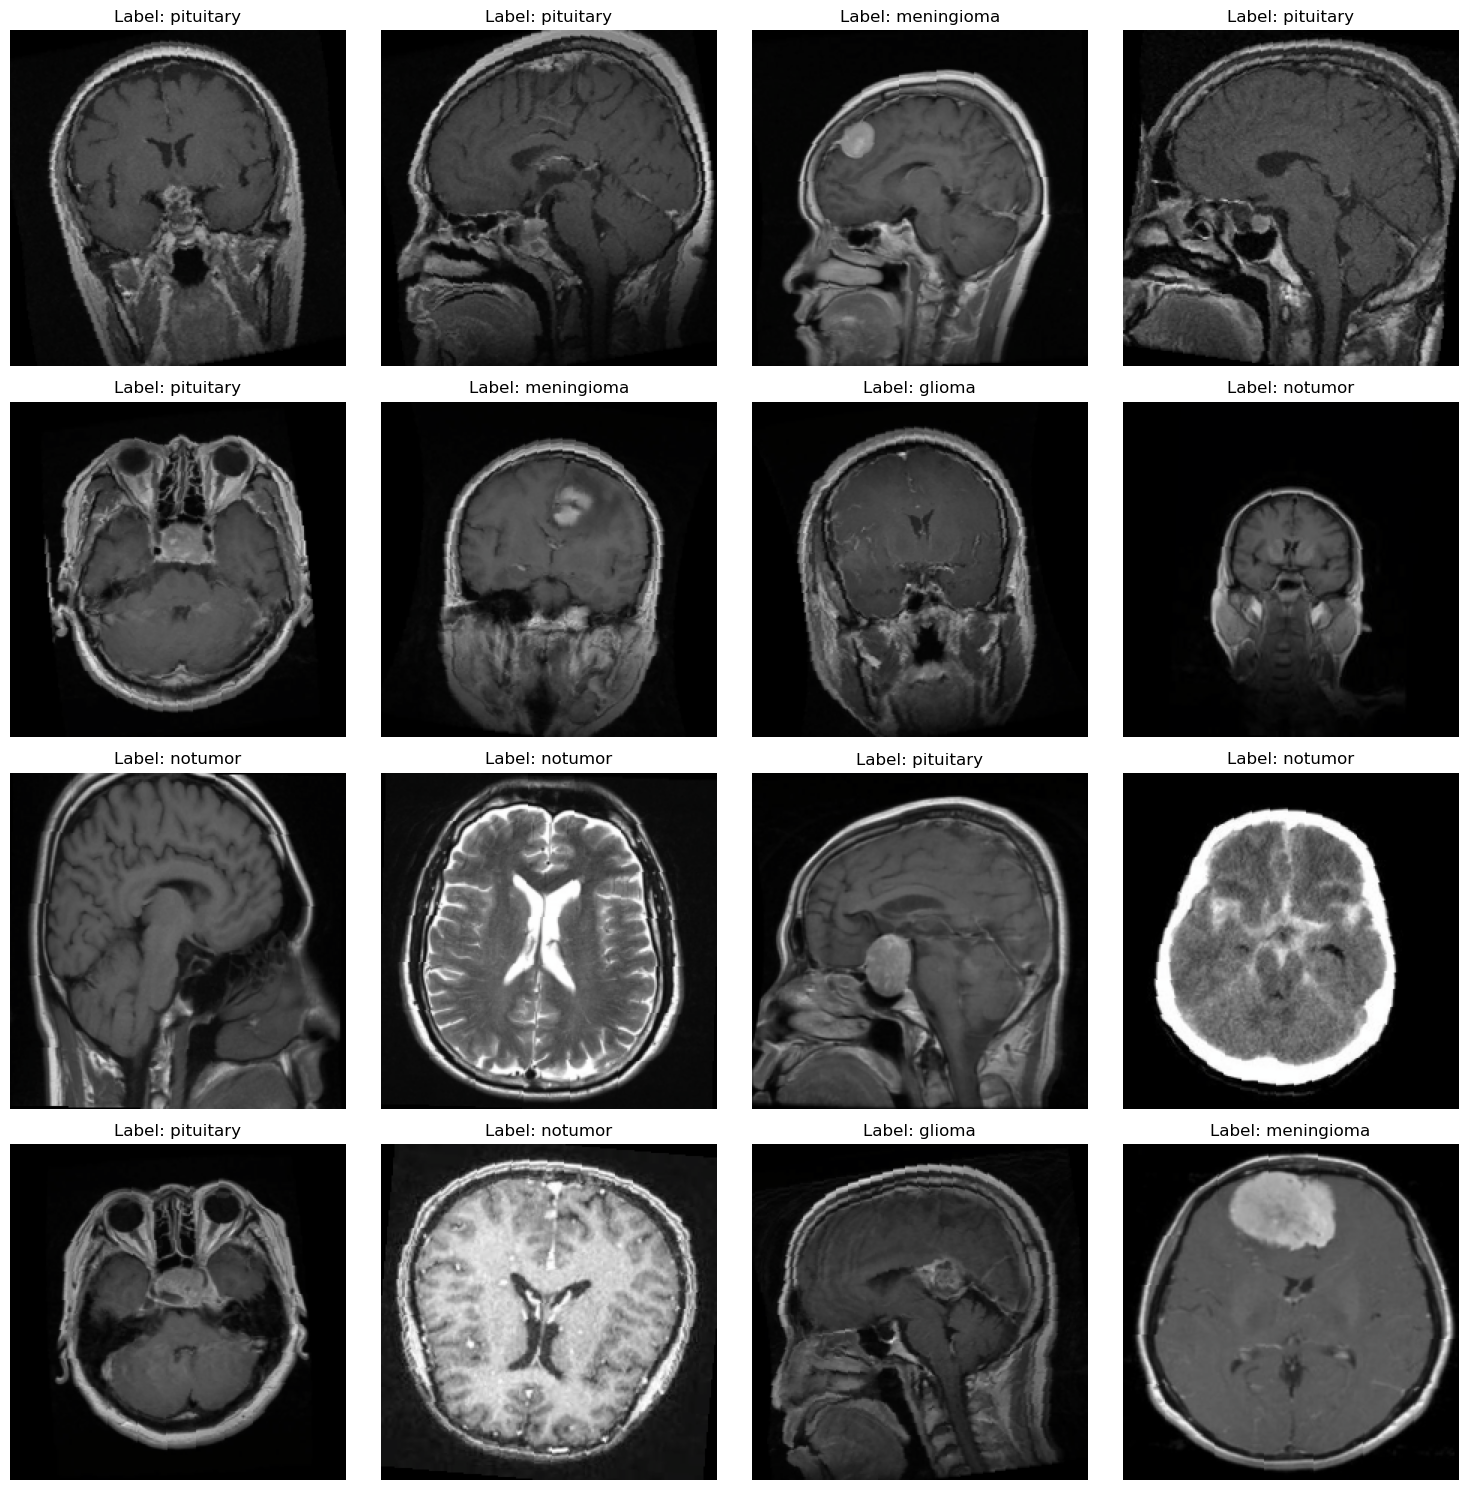

In [4]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [7]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [8]:
# Training loop
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


Epoch [1/10], Training Loss: 253.3067, Training Accuracy: 75.81%, Validation Loss: 0.4435, Validation Accuracy: 82.61%
Epoch [2/10], Training Loss: 114.6713, Training Accuracy: 88.34%, Validation Loss: 0.4471, Validation Accuracy: 83.91%
Epoch [3/10], Training Loss: 78.9476, Training Accuracy: 91.79%, Validation Loss: 0.2296, Validation Accuracy: 91.53%
Epoch [4/10], Training Loss: 54.4947, Training Accuracy: 94.49%, Validation Loss: 0.1649, Validation Accuracy: 94.43%
Epoch [5/10], Training Loss: 43.5046, Training Accuracy: 95.69%, Validation Loss: 0.1557, Validation Accuracy: 94.97%
Epoch [6/10], Training Loss: 33.1286, Training Accuracy: 96.92%, Validation Loss: 0.1649, Validation Accuracy: 94.51%
Epoch [7/10], Training Loss: 30.5782, Training Accuracy: 97.09%, Validation Loss: 0.1481, Validation Accuracy: 94.89%
Epoch [8/10], Training Loss: 20.5733, Training Accuracy: 97.97%, Validation Loss: 0.0992, Validation Accuracy: 97.18%
Epoch [9/10], Training Loss: 16.4817, Training Accurac

# Model Evaluation

In [9]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 96.34%


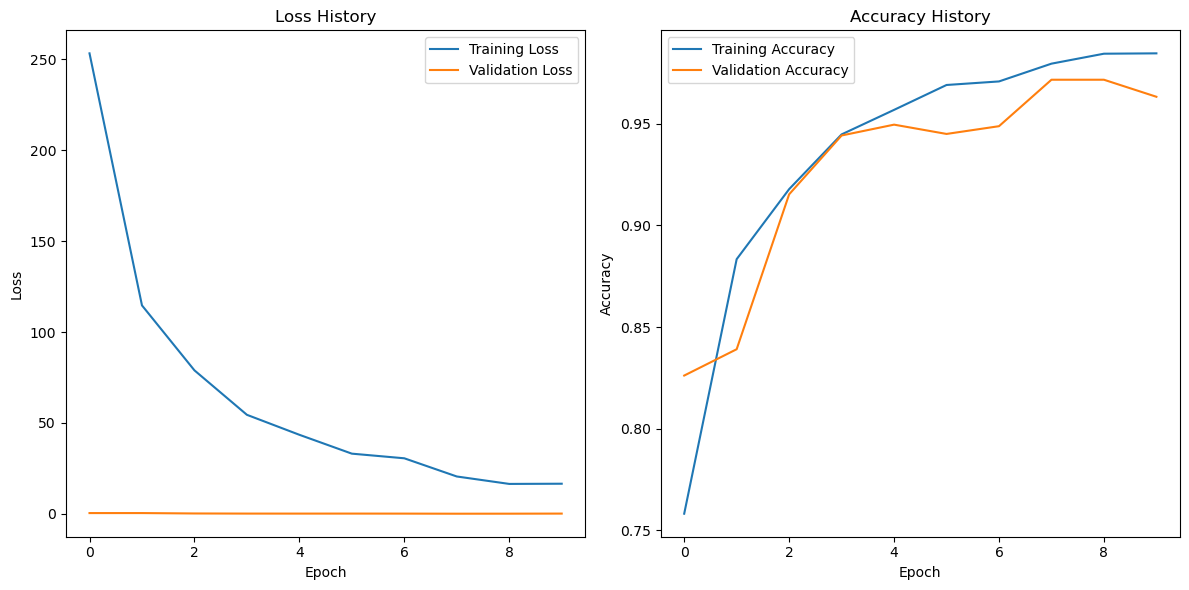

In [10]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

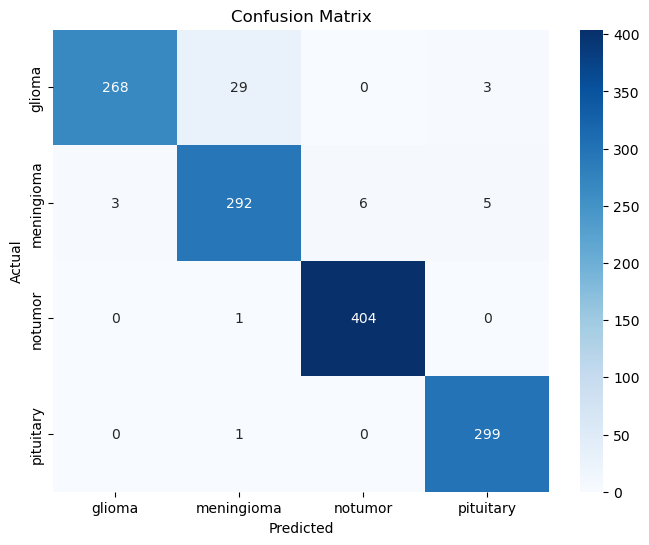

In [11]:
model.eval()
y_true = []
y_pred = []
y_pred_prob = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(probs.cpu().numpy()[:, 1])  

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
# 2. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       300
  meningioma       0.90      0.95      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



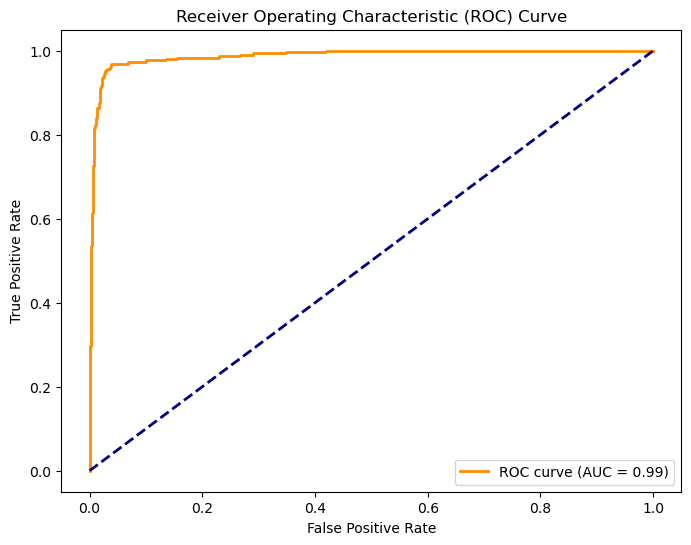

In [13]:
# 3. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob, pos_label=1)  
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Saving Model

In [14]:
torch.save(model.state_dict(), 'best_model.pth')
print('Model Saved Sucssfully !')

Model Saved Sucssfully !


# Try Model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TumorClassifier(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  
model.eval()  

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


# Upload Photo

The predicted class is: No Tumor


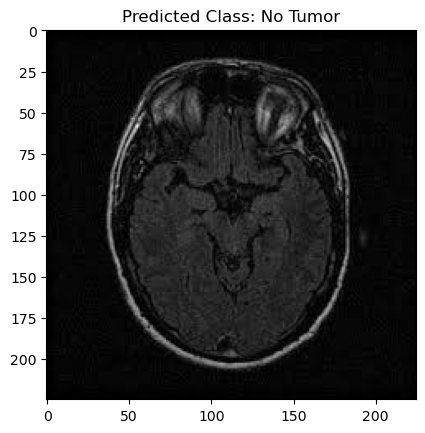

In [16]:
image_path = '/kaggle/input/no-tumer/tensorflow2/default/1/no.jpg'  
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) 

input_batch = input_batch.to(device)

with torch.no_grad():  
    outputs = model(input_batch)  
    _, predicted = torch.max(outputs, 1)  

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Meningioma


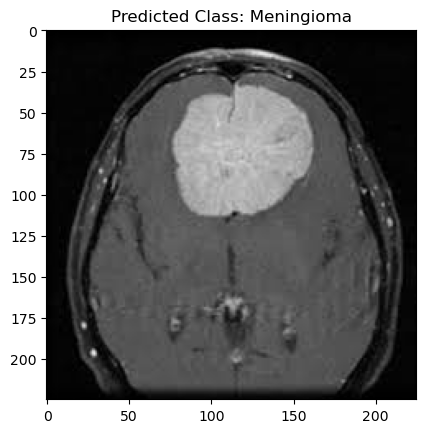

In [17]:
image_path = '/kaggle/input/meningioma/tensorflow2/default/1/Meningioma.jpg'  
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) 

input_batch = input_batch.to(device)

with torch.no_grad():  
    outputs = model(input_batch)  
    _, predicted = torch.max(outputs, 1)  

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Glioma


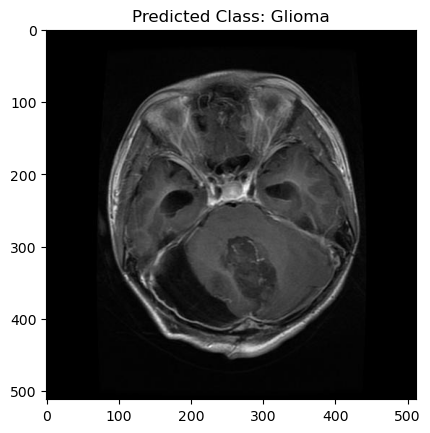

In [18]:
image_path = '/kaggle/input/giloma/tensorflow2/default/1/glioma (2).jpg'  
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) 

input_batch = input_batch.to(device)

with torch.no_grad():  
    outputs = model(input_batch)  
    _, predicted = torch.max(outputs, 1)  

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Pituitary


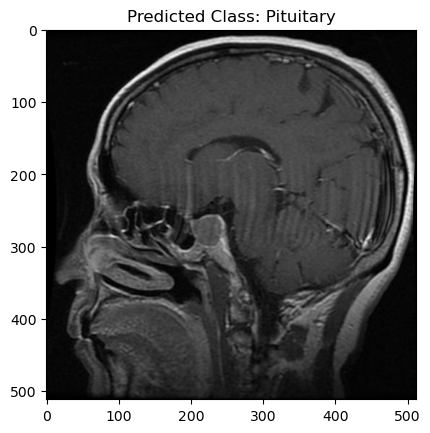

In [19]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0007.jpg'  
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0) 

input_batch = input_batch.to(device)

with torch.no_grad():  
    outputs = model(input_batch)  
    _, predicted = torch.max(outputs, 1)  

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()